#  Herculens point sources : lenstronomy comparison

In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', interpolation='none')

# Basic imports
import numpy as np
from functools import partial

# JAX-related imports
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.MassModel.mass_model import MassModel
from herculens.LightModel.light_model import LightModel
from herculens.PointSourceModel.point_source_model import PointSourceModel
from herculens.LensImage.lens_image import LensImage

# Lenstronomy for comparison
from lenstronomy.Data.pixel_grid import PixelGrid as PixelGridL
from lenstronomy.Data.psf import PSF as PSFL
from lenstronomy.LensModel.lens_model import LensModel as LensModelL
from lenstronomy.LightModel.light_model import LightModel as LightModelL
from lenstronomy.PointSource.point_source import PointSource as PointSourceL
from lenstronomy.ImSim.image_model import ImageModel as ImageModelL

## Pixel grid

In [2]:
npix = 100  # number of pixels per side
pix_size = 5. / npix  # angular pixel size [arcsec]
plane_half_size = 0.5 * npix * pix_size  # half image angular extent per side [arcsec]
ra_at_xy_0 = dec_at_xy_0 = -plane_half_size + 0.5 * pix_size  # angular coordinates of the pixel (0, 0)
transform_pix2angle = pix_size * np.eye(2)  # transformation matrix between pixel and angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# Create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_size} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

# Lenstronomy
pixel_grid_L = PixelGridL(**kwargs_pixel)

image size : (100, 100) pixels
pixel size : 0.05 arcsec
x range    : (-2.475, 2.475) arcsec
y range    : (-2.475, 2.475) arcsec


## Mass model

In [3]:
mass_model_list = ['SIE', 'SHEAR']
mass_model = MassModel(mass_model_list)
kwargs_sie = {'theta_E': 1.4, 'e1': 0.2, 'e2': 0.0, 'center_x': 0, 'center_y': 0}
kwargs_shear = {'gamma1': 0.02, 'gamma2': 0.08}
kwargs_lens = [kwargs_sie, kwargs_shear]

# Lenstronomy
lens_model_L = LensModelL(mass_model_list)

## Source light model

In [4]:
# source_model = LightModel(['GAUSSIAN'])
# kwargs_source = [{'amp': 1.0, 'sigma': 0.005, 'center_x': 0.075, 'center_y': -0.05}]

source_light_model_list = ['SERSIC']
source_model = LightModel(source_light_model_list)
kwargs_source = [{'amp': 1, 'R_sersic': 0.5, 'n_sersic': 2, 'center_x': 0.072, 'center_y': -0.05}]

# Lenstronomy
source_model_L = LightModelL(source_light_model_list)

## PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.12, 'truncation': 5}
psf = PSF(**kwargs_psf)
psf.set_pixel_size(pixel_grid.pixel_width)

# Lenstronomy
psf_L = PSFL(**kwargs_psf)
psf_L.set_pixel_size(pixel_grid.pixel_width)

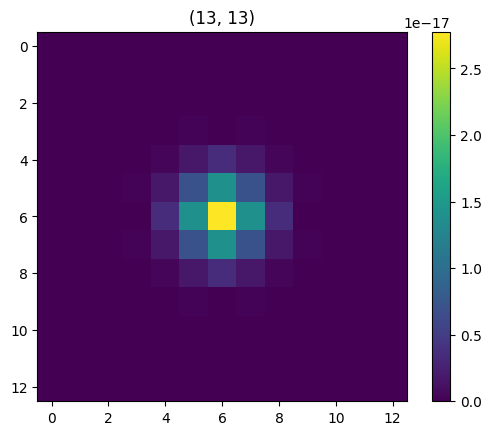

In [6]:
fig, ax = plt.subplots(1, 1)
img = ax.imshow(abs(psf.kernel_point_source - psf_L.kernel_point_source))
ax.set_title(psf.kernel_point_source.shape)
fig.colorbar(img)

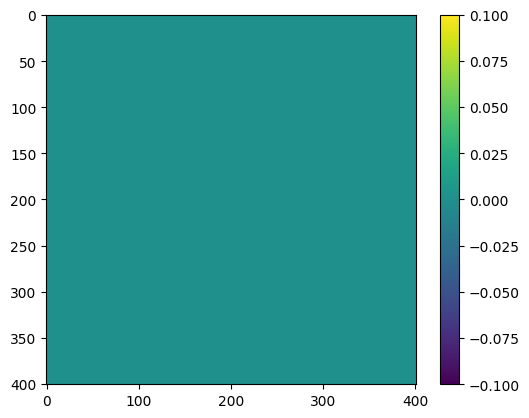

In [7]:
fig, ax = plt.subplots(1, 1)
img = ax.imshow(abs(psf.kernel_point_source_supersampled(4) - psf_L.kernel_point_source_supersampled(4)))
fig.colorbar(img)

# Point Source

In [9]:
point_source_model = PointSourceModel(['IMAGE_POSITIONS'], mass_model)
kwargs_point_source = [{'ra': [1.51234, 0.81234, -0.91234], 
                        'dec': [0.71234, -1.31234, 1.61234], 
                        'amp': [1., 2., 14.]}]


point_source_L = PointSourceL(['LENSED_POSITION'])
kwargs_ps_L = [{'ra_image': kwargs_point_source[0]['ra'], 
                'dec_image': kwargs_point_source[0]['dec'], 
                'point_amp': kwargs_point_source[0]['amp']}]

In [10]:
# point_source_model.image_positions(kwargs_point_source)

In [11]:
# point_source_model.source_positions(kwargs_point_source, kwargs_lens)

In [12]:
# point_source_model.image_amplitudes(kwargs_point_source)

In [13]:
# point_source_model.source_amplitudes(kwargs_point_source, kwargs_lens)

## Image model

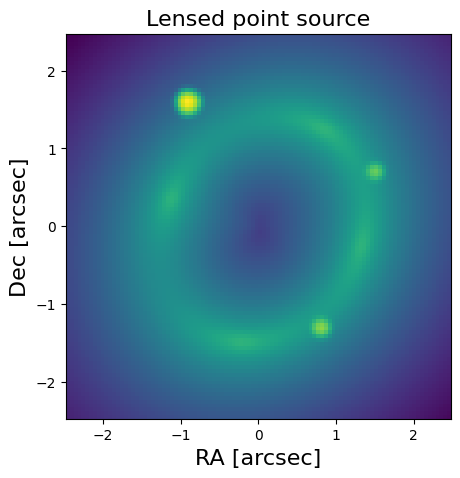

In [14]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 3, 'point_source_supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf,
                       lens_mass_model_class=mass_model,
                       source_model_class=source_model,
                       point_source_model_class=point_source_model,
                       kwargs_numerics=kwargs_numerics)

kwargs_all = dict(kwargs_lens=kwargs_lens,
                  kwargs_source=kwargs_source,
                  kwargs_lens_light={},
                  kwargs_point_source=kwargs_point_source
                 )
image = lens_image.model(**kwargs_all, point_source_add=True)
# image = lens_image.model(**kwargs_all)
# image += 0.01
log_image = np.log(image)

# visualize simulated products
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(log_image, origin='lower', extent=pixel_grid.extent)
ax.set_aspect('equal')
ax.set_title('Lensed point source', fontsize=16)
ax.set_xlabel('RA [arcsec]', fontsize=16)
ax.set_ylabel('Dec [arcsec]', fontsize=16);
# plt.savefig('/Users/austinpeel/Desktop/lensed_pt_src.png', format='png')

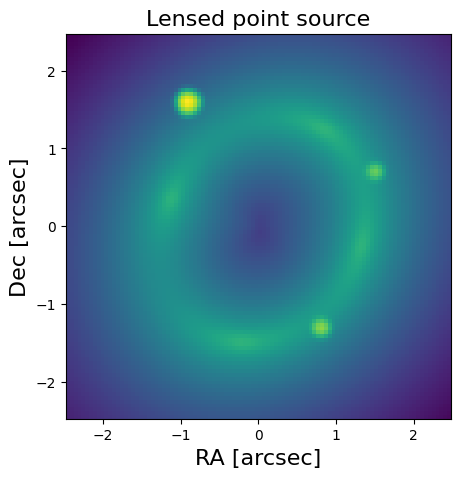

In [15]:
# Lenstronomy
lens_image_L = ImageModelL(pixel_grid_L, psf_L,
                       lens_model_class=lens_model_L,
                       source_model_class=source_model_L,
                       point_source_class=point_source_L,
                       kwargs_numerics=kwargs_numerics)

kwargs_all_L = dict(kwargs_lens=kwargs_lens,
                  kwargs_source=kwargs_source,
                  kwargs_lens_light={},
                  kwargs_ps=kwargs_ps_L
                   )
image_L = lens_image_L.image(**kwargs_all_L, point_source_add=True)
# image_L += 0.01
log_image_L = np.log(image_L)

# visualize simulated products
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(log_image_L, origin='lower', extent=pixel_grid.extent)
ax.set_aspect('equal')
ax.set_title('Lensed point source', fontsize=16)
ax.set_xlabel('RA [arcsec]', fontsize=16)
ax.set_ylabel('Dec [arcsec]', fontsize=16);

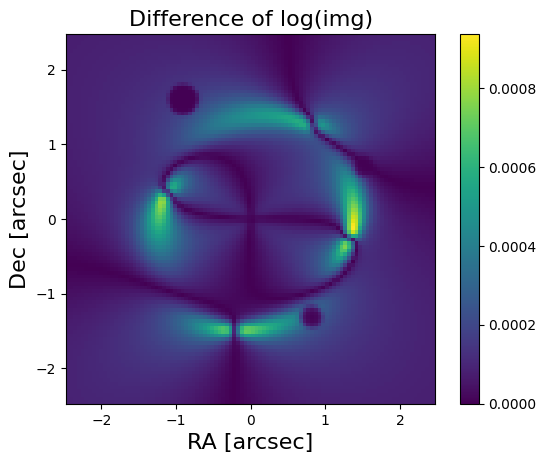

In [16]:
fig, ax = plt.subplots(1, 1)
log_diff = log_image - log_image_L
# img = ax.imshow(abs(diff) > 0.0001, origin='lower', extent=pixel_grid.extent)
img = ax.imshow(abs(log_diff), origin='lower', extent=pixel_grid.extent, vmin=0)
ax.set_aspect('equal')
ax.set_title('Difference of log(img)', fontsize=16)
ax.set_xlabel('RA [arcsec]', fontsize=16)
ax.set_ylabel('Dec [arcsec]', fontsize=16)
fig.colorbar(img)

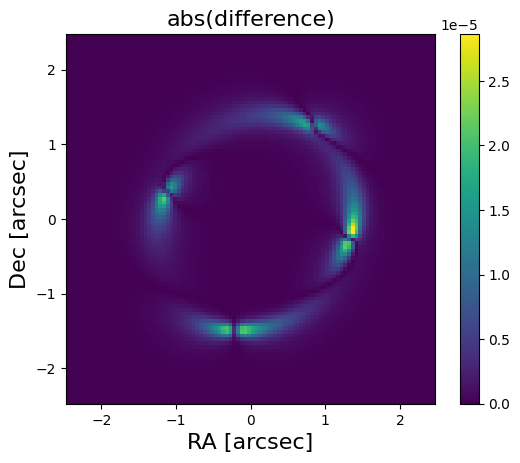

In [17]:
fig, ax = plt.subplots(1, 1)
diff = image - image_L
# img = ax.imshow(abs(diff) > 0.0001, origin='lower', extent=pixel_grid.extent)
img = ax.imshow(abs(diff), origin='lower', extent=pixel_grid.extent, vmin=0)
ax.set_aspect('equal')
ax.set_title('abs(difference)', fontsize=16)
ax.set_xlabel('RA [arcsec]', fontsize=16)
ax.set_ylabel('Dec [arcsec]', fontsize=16)
fig.colorbar(img)